In [1]:
!export CUDA_LAUNCH_BLOCKING=1

In [25]:
from tokenizer import Tokenizer

In [3]:
with open("input.txt", 'r', encoding='utf-8') as f:
    text = f.read()

In [26]:
# string_to_int = {c : i for i, c in enumerate(chars)}
# int_to_string = {i : c for i, c in enumerate(chars)}

# encode = lambda x : [string_to_int[i] for i in x]
# decode = lambda x : ''.join([int_to_string[i] for i in x])

# print(encode("hii there"))
# print(decode(encode("hii there")))

tokenizer = Tokenizer("./tokenizer_tokens")
encode, decode = tokenizer.encode, tokenizer.decode
vocab_size = len(tokenizer._vocab) + 2

In [5]:
example_input = tokenizer.encode('''First Citizen:
Before we proceed any further, hear me speak.''')
print(example_input)
print(tokenizer.decode(example_input))

[98, 97, 583, 618, 480, 444, 594, 135, 334, 266, 619, 470, 3, 506, 496, 618, 492, 618, 493, 385, 313, 618, 108, 548, 618, 59, 471, 270, 49, 618, 50, 134, 618, 66, 618, 184, 113, 272, 305]
['F', 'ir', 'st', ' ', 'C', 'it', 'i', 'z', 'en', ':', '\n', 'B', 'ef', 'or', 'e', ' ', 'we', ' ', 'pro', 'ce', 'ed', ' ', 'an', 'y', ' ', 'f', 'ur', 'ther', ',', ' ', 'he', 'ar', ' ', 'me', ' ', 'sp', 'ea', 'k', '.']
First Citizen:
Before we proceed any further, hear me speak.


In [6]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([745877]) torch.int64
tensor([ 98,  97, 583, 618, 480, 444, 594, 135, 334, 266, 619, 470,   3, 506,
        496, 618, 492, 618, 493, 385, 313, 618, 108, 548, 618,  59, 471, 270,
         49, 618,  50, 134, 618,  66, 618, 184, 113, 272, 305, 619, 619, 166,
        489, 266, 619, 301,  61, 604,  49, 618, 184, 113, 272, 305, 619, 619,
         98,  97, 583, 618, 480, 444, 594, 135, 334, 266, 619, 505, 411, 618,
        255, 618, 354, 618,  90, 254, 460, 605, 618, 379, 270, 618, 512, 618,
        248, 496, 618, 366, 441, 618, 512, 618, 242, 308, 557, 390, 619, 619,
        166, 489])


In [7]:
n = int(0.9 * len(data))

train_data = data[:n]
val_data = data[n:]

In [8]:
block_size = 8
train_data[:block_size+1]

tensor([ 98,  97, 583, 618, 480, 444, 594, 135, 334])

In [9]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

# NOTE: The reason you want to do this is because you want the transformer to learn the context for various amounts of inputs

when input is tensor([98]) the target: 97
when input is tensor([98, 97]) the target: 583
when input is tensor([ 98,  97, 583]) the target: 618
when input is tensor([ 98,  97, 583, 618]) the target: 480
when input is tensor([ 98,  97, 583, 618, 480]) the target: 444
when input is tensor([ 98,  97, 583, 618, 480, 444]) the target: 594
when input is tensor([ 98,  97, 583, 618, 480, 444, 594]) the target: 135
when input is tensor([ 98,  97, 583, 618, 480, 444, 594, 135]) the target: 334


In [10]:
torch.manual_seed(1337)

batch_size = 4
block_size = 8

def get_batch(split):
    data = train_data if split == "train" else val_data
    idx = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in idx])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in idx])

    return x, y

xb, yb = get_batch('train')

In [11]:
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"When input is {context.tolist()} the target is {target}")
    break

When input is [618] the target is 401
When input is [618, 401] the target is 618
When input is [618, 401, 618] the target is 536
When input is [618, 401, 618, 536] the target is 51
When input is [618, 401, 618, 536, 51] the target is 305
When input is [618, 401, 618, 536, 51, 305] the target is 619
When input is [618, 401, 618, 536, 51, 305, 619] the target is 619
When input is [618, 401, 618, 536, 51, 305, 619, 619] the target is 511


In [12]:
class LayerNorm:
    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    
    def __call__(self, x):
        ''' Applying LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html '''
        
        xmean = x.mean(1, keepdim=True)
        xvar = x.var(1, keepdim=True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to mean 0, var 1
        return self.gamma * xhat + self.beta
    
    def parameters(self):
        return [self.gamma, self.beta]

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F

n_embd = 384
n_head = 6
n_layers = 6
dropout = 0.2
device = "cuda"
block_size = 128

class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    
    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)

        weights = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, 16) @ (B, 16, T) -> (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        weights = F.softmax(weights, dim=1) # (B, T, T)

        v = self.value(x)
        out = weights @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size) # Communication
        self.ffwd = FeedForward(n_embd) # Computation
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        # x = x + ___ is for skip/residual connection, helps with optimization
        # this is because addition distributes gradients evenly -> at the beginning, the block won't do much and
        # you'll have like a gradient highway from output -> input. Over time as the optimization happens, sa and ffwd will
        # become more apparent
        
        # Apply layernorm before sa and ffwd, slight deviation from the paper
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [14]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Embedding(num_embeddings, embedding_dim) -> num_embeddings is the size of the embedding dictionary
        # while embedding_dim is the size of the embeddings
         
        # Cast the tokens to token embeddings, then use a linear layer to convert that into the final logits
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        
        # position embeddings, each item in the block size gets its own embedding
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layers)])

        self.blocks = nn.Sequential(
            Block(n_embd, n_head),
            Block(n_embd, n_head=4),
            Block(n_embd, n_head=4),
            nn.LayerNorm(n_embd),
        )

        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T).to(device)) # (T, n_embd)

        x = tok_emb + pos_emb # (B, T, C)
        
        x = self.blocks(x) # (B, T, C)

        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) array, we want to make it 
        # (B, T + 1) -> (B, T + 2) -> etc.
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:] # because we're using positional embeddings, we can only give the last block_size idxs

            logits, loss = self(idx_cond) # get predictions
            logits = logits[:, -1, :] # logits are (B, T, C), want to get the last logits in time dimension (B, C)
            probs = F.softmax(logits, dim=1) # apply softmax to get probabilities (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # sample from probability distributions to get predictions, (B, 1)

            idx = torch.cat((idx, idx_next), dim=1) # add the current timestep predictions to the running predictions, (B, T + 1)
    
        return idx

m = BigramLanguageModel().to(device)

In [15]:
logits, loss = m(xb.to(device), yb.to(device))
print(logits.shape)
print(loss)

torch.Size([32, 620])
tensor(6.6415, device='cuda:0', grad_fn=<NllLossBackward0>)


In [16]:
idx = torch.zeros((1, 1), dtype=torch.long) # kick off the generation with a 0
print(decode(m.generate(idx.to(device), max_new_tokens=100)[0].tolist()))

['ess', ':', 'ap', 'tr', 'B', 'fe', 'O', 'I', 'am', 'U', 'od', 'lt', 'end', 'ion', 'res', 'a', 'ir', 'B', 'lu', 'ac', 'ig', 'be', 'ce', 'l', 'us', 'pe', 'co', 'ia', 'al', 'art', 'rse', 'om', 'oa', 'ten', 'pe', 'ath', 'ti', 'est', "'d", 'ss', 'm', 'lo', 'ti', 'X', 'se', 'fi', 'la', 'che', 'lt', 'sa', 'wa', 'ent', 'rn', 'ere', 'ol', 'an', 'pi', 'r', 'do', 'bu', 'em', 'fi', 'ab', 'ex', 'z', "'", 'p', 'des', 'pro', 'an', 'Y', 'age', 'tin', '--', 'na', 'ig', 'pl', 'j', 'D', 'iv', 'se', 'ts', 'ef', 'j', 'U', 'che', 'ch', 'wo', 'ho', 'che', 'tin', 'j', 'ad', 'n,', 'us', 'ef', 'cu', 'N', 'an', 'ght', 'sc']
ess:aptrBfeOIamUodltendionresairBluacigbeceluspecoiaalartrseomoatenpeathtiest'dssmlotiXsefilacheltsawaentrnereolanpirdobuemfiabexz'pdesproanYagetin--naigpljDivsetsefjUchechwohochetinjadn,usefcuNanghtsc


In [17]:
optimizer = torch.optim.AdamW(m.parameters(), lr=3e-4)

In [18]:
eval_iters = 200

@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train', 'eval']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = m(X.to(device), Y.to(device))
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out

In [19]:
from tqdm import tqdm
batch_size = 64
eval_every = 500

train_loss = []
test_loss = []

for steps in tqdm(range(20000)):
    xb, yb = get_batch('train')

    logits, loss = m(xb.to(device), yb.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if steps % eval_every == 0:
        losses = estimate_loss()
        train_loss.append(losses['train'])
        test_loss.append(losses['eval'])

100%|██████████| 20000/20000 [19:18<00:00, 17.26it/s]  


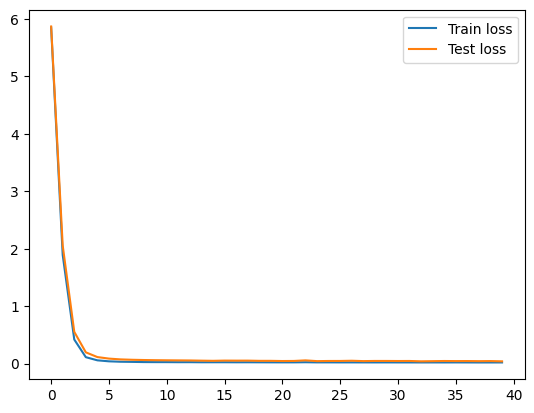

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="Train loss")
plt.plot(range(len(train_loss)), test_loss, label="Test loss")
plt.legend()


In [21]:
import math
print("The loss for a model that chooses randomly from the 65 tokens:", -1 * math.log(1/65))
print(f"Train loss: {estimate_loss()['train']}, Test Loss: {estimate_loss()['eval']}")

The loss for a model that chooses randomly from the 65 tokens: 4.174387269895637
Train loss: 0.01748487912118435, Test Loss: 0.04011920094490051


In [27]:
print(decode(m.generate(idx.to(device), max_new_tokens=2000)[0].tolist()))

['ess', 'ar', 'fi', 'nes', 'da', 'ec', 'A', 'ul', 'ir', 'ef', 'su', 'ga', 'ef', 'ef', 'll', 'ig', 'av', 'ga', 'ig', 're', 'ak', 'ight', 'ga', 'co', 'ga', 're', 'ight', 'ight', 'ne', 'are', "'", 'we', 'su', 'ight', 'all', 'su', 'are', 'su', 'om', "'", 'ight', 'ne', "'", "'", 'su', 'ef', 'su', 't:', 'ne', 'su', 're', 'ga', 'am', "'", 'su', 'su', 'mb', 'sta', 'mb', 'nes', 'sta', 'ght', 'one', 'iv', "'", 'su', 'su', 'su', 'su', 'su', 'su', 'su', 'gu', 'gu', 'su', 'gu', 'and', 'iv', 'one', 'ne', 'gu', 'su', 'su', 'su', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ight', 'ia', "'", "'", 't.', 'e,', 'M', '!', 'e,', ',', '!', ' ', 'am', ' ', 'es', 'on', 'ab', 'le', '?', '\n', '\n', 'A', 'nd', 's:', ' ', 'C', 'or', 'li', 'sh', 'i', 'p', 's', ' ', 'b', 'y', ' ', 'the', ' ', 'po', 'or', '

![alt text](https://quantdare.com/wp-content/uploads/2021/11/transformer_arch.png "Image")

In [25]:
# There is one big difference in the architecture in the paper and the network we made - namely, that we made a decoder-only model. Our model takes in the tokens and uses that context to reproduce text that looks like the input text
# The original paper was a machine translation paper, where it took a french sentence ("J'aime manger les pommes") and translated it into an english sentence ("I like to eat apples").
# What would happen is the self-attention would first happen on the french sentence, except the upper triangular mask wasn't applied. This would let all the tokens communicate with each other. Then this would create some output embedding, which would then be the input to the decoder. Then, in the multi-head attention in the decoder, there'd be a cross attention, where the query and key would come from the output of the encoder, but the value would come from the decoder.
# Note that in the decoder, the multi-head attention would still have that mask.
# Anyways, in our example, we don't really have that encoder bit because we're not trying to capture any context from something that's the equivalent of the french sentence. We only are trying to generate Shakespeare, so we only really need the last block_size tokens.

### The mathematical trick in self-attention

In [ ]:
# Consider the following example:

torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# We want the tokens to communicate, but only with previous tokens
# For example, we want the token in the 5th position to only communicate with those in the 1st, 2nd, 3rd, and 4th
# What's the simplest way to do this? For now, let's take the average of all the elements that came before it
# Granted, this is pretty weak, but let's take the (B, T, C), then for each idx, compute the average channel values for
# everything that came before it

# Currently using for loops so this is purposely slow
xbow = torch.zeros(B, T, C)
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]
        xbow[b, t] = torch.mean(xprev, 0)

In [ ]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [ ]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [ ]:
# Turns out you can make this faster by using matrix multiplication, using lower triangular matrices
# Ex:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3,2)).float()
c = a @ b

print(a)
print(b)
print(c)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# To replicate the average quickly, we can do this:
weights = torch.tril(torch.ones(T, T))
weights = weights / weights.sum(1, keepdim=True)
xbow2 = weights @ x # (B, T, T) @ (B, T, C) --> (B, T, C)

torch.allclose(xbow, xbow2) # shows they're the same

True

In [ ]:
# We can replicate this with softmax, which is a bit more interesting
tril = torch.tril(torch.ones(T, T))
weights = torch.zeros((T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)
xbow3 = weights @ x
torch.allclose(xbow, xbow3)

# The reason we do this is because eventually, we're going to fill that weights matrix with things other than 0
# You can think of the weights matrix as representing affinities or relationships between the tokens because
# the average is basically weighted by them (via softmax)
# Weights set the relationships, the tril will make sure that future tokens can't communicate with previous ones

True

In [ ]:
# Before, we're initializing the weights with all zeros, but we want it to represent the affinities between the different tokens
# Every token at each position will have two vectors: a key and a query
#   - Query: what am I looking for?
#   - Key: what do I contain?
# The affinity between two tokens will be the dot product of the key and the query -> that makes up the weights matrix

torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

# One head of self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) # (B, T, head_size) "This is what I have"
q = query(x) # (B, T, head_size) "This is what I want"

weights = q @ k.transpose(-2, -1) # ( B, T, 16) @ (B, 16, T) -> (B, T, T)

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=1)

v = value(x) # "If you find me interesting, here's what I will communicate with you"
out = weights @ v

In [ ]:
weights[0] 

tensor([[0.0248, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0052, 0.0091, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0521, 0.0135, 0.2482, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3171, 0.0214, 0.1642, 0.1188, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0412, 0.0487, 0.1046, 0.0742, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1060, 0.5347, 0.2059, 0.1030, 0.7402, 0.0192, 0.0000, 0.0000],
        [0.4298, 0.3409, 0.1769, 0.2027, 0.0480, 0.8472, 0.2329, 0.0000],
        [0.0238, 0.0316, 0.1002, 0.5013, 0.0117, 0.1336, 0.7671, 1.0000]],
       grad_fn=<SelectBackward0>)

In [ ]:
# NOTES: 
# Attention is a communication mechanism, can be represented as a directed graph where you're taking the weighted sum of all nodes that point to you --> in this case, you have a special graph where node 1 only points to itself, node 2 is pointed to by node 1 and itself, ...
# There isn't a notion of space, so you need to add in the positional encoding
# The different examples in the batch don't communicate, only within an example
# We implemented a decoder block where we have the mask with the triangular matrix, but you can have an encoder block where you allow future tokens to communicate with past ones -- this is useful for something like sentiment analysis, where you're not predicting a next token (if you want to do this, remove the masked_fill line)
# self-attention means keys, queries, values come from the same source (x). Cross attention is when you have some external source where queries come from x, but keys and values can come from some other external source (like an encoder module)
# We need to used scaled attention, where you divide weights by sqrt(head_size)

k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
weights = q @ k.transpose(-2, -1)

print("Without scaling")
print(k.var(), q.var(), weights.var()) # variation of weights is on the order of head_size, which is bad

print("\nWith scaling")
print(k.var(), q.var(), (weights * head_size**-0.5).var()) # if there's 1 variance in k, q, there's 1 variance in weights

Without scaling
tensor(1.0449) tensor(1.0700) tensor(17.4690)

With scaling
tensor(1.0449) tensor(1.0700) tensor(1.0918)


In [ ]:
# Ideally, you want the initialization to be diffuse, if you have super positive and super negative numbers, then the softmax
# will converge to one-hot vectors, ex:

print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * 8, dim=-1)) # more like a one-hot at max

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])
